<h1><u><font color='red'>Step 1</font></u></h1>

#### Prepare workspace

<h4><font color='blue'>Import libraries</font></h4>

In [1]:
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import MultiPoint
import ee
import matplotlib.pyplot as plt
import json
import requests
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON
import geojson
import rasterio
from rasterio.features import rasterize
from rasterio.mask import mask
import os
import os
import osmnx as ox
import geopandas as gpd
import pandas as pd
import glob
from math import sqrt, ceil
from shapely.geometry import Polygon
import shapefile
import shutil
import pyproj
import rasterio
import rasterio.features
import folium
from tqdm import tqdm
import warnings
import fiona
import folium
import ee
import geemap
from ipyleaflet import TileLayer, basemaps
import json
import requests
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON
import geojson
import geemap.colormaps as cm
import rasterio
from rasterio.plot import reshape_as_image
from geemap.legends import builtin_legends
import rasterio
from rasterstats import zonal_stats
from matplotlib.lines import Line2D

print("All libraries imported")

All libraries imported


<h4><font color='blue'>Initializa and authenticate GEE</font></h4>

In [2]:
ee.Authenticate()
ee.Initialize()

<h1><u><font color='red'>Step 2</font></u></h1>

#### Prepare working datasets

<h4><font color='blue'>Import datasets</font></h4>

In [3]:
#Import datasets
Bound = r"C:\Users\marti\unhabitat\10_Palestine_Final\Boundaries\Gaza_Strip_Bound.shp"
Degurba_L1 = r"C:\Users\marti\unhabitat\10_Palestine_Final\Degurba\L1_Degurba.shp"
National_Boundary = r"C:\Users\marti\unhabitat\10_Palestine_Final\Boundaries\Gaza_Strip.shp"
CDA_Assessment = r"C:\Users\marti\unhabitat\09_Palestine\Raster\damage\CDA_Mask2.shp"

#Read datasets
National_Boundary = gpd.read_file(National_Boundary)
Bound = gpd.read_file(Bound)
Degurba = gpd.read_file(Degurba_L1)
CDA_Assessment = gpd.read_file(CDA_Assessment)

#Convert items to GEE objects
## Convert National boundary area to gee object
boundary = National_Boundary.to_crs('EPSG:4326')
boundary_js = json.loads(boundary.to_json())
Bound_geom = ee.Geometry(ee.FeatureCollection(boundary_js).geometry())
##Bound
BBox = Bound.to_crs('EPSG:4326')
Bbox_js = json.loads(BBox.to_json())
Bbox = ee.Geometry(ee.FeatureCollection(Bbox_js).geometry())
##CDA_Assessment
CDA = CDA_Assessment.to_crs('EPSG:4326')
CDA_js = json.loads(CDA.to_json())
Affected_areas = ee.Geometry(ee.FeatureCollection(CDA_js).geometry())

<h4><font color='blue'>Select urban and rural areas from degurba dataset</font></h4>

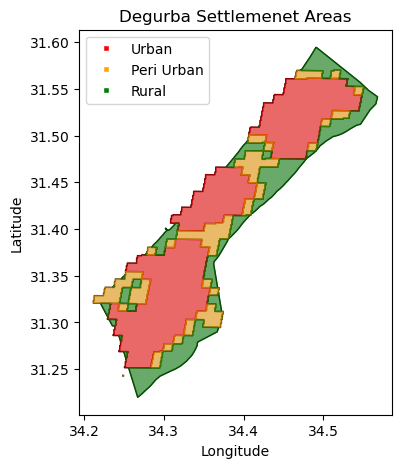

In [4]:
# Define urban and rural categories
urban_code = 3
periurban_code = 2
rural_code = 1

# Create a new column to store the category
Degurba['category'] = None

# Assign categories based on gridcode
Degurba.loc[Degurba['gridcode'] == urban_code, 'category'] = 'Urban'
Degurba.loc[Degurba['gridcode'] == periurban_code, 'category'] = 'Peri_Urban'
Degurba.loc[Degurba['gridcode'] == rural_code, 'category'] = 'Rural'

# Dissolve urban and rural areas separately
urban_areas = Degurba[Degurba['category'] == 'Urban'].dissolve(by='category')
periurban_areas = Degurba[Degurba['category'] == 'Peri_Urban'].dissolve(by='category')
rural_areas = Degurba[Degurba['category'] == 'Rural'].dissolve(by='category')

# Plot urban and rural areas
fig, ax = plt.subplots(figsize=(5, 5))
Degurba.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot all areas in light grey
urban_areas.plot(ax=ax, color='red', alpha=0.5, edgecolor='red', label='Urban')  # Plot urban areas in red
periurban_areas.plot(ax=ax, color='orange', alpha=0.5, edgecolor='orange', label='Peri_Urban')  # Plot urban areas in red
rural_areas.plot(ax=ax, color='green', alpha=0.5, edgecolor='green', label='Rural')  # Plot rural areas in green

#Plot
# Create custom legend
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Urban', markerfacecolor='red', markersize=5),
                   Line2D([0], [0], marker='s', color='w', label='Peri Urban', markerfacecolor='orange', markersize=5),
                   Line2D([0], [0], marker='s', color='w', label='Rural', markerfacecolor='green', markersize=5)]

# Add legend to the plot
ax.legend(handles=legend_elements, loc='upper left')
plt.title('Degurba Settlemenet Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


<h4><font color='blue'>Create custom urban and rural areas of interest</font></h4>

<blockquote>This is based on overlay between built up area, and a 100m grid</blockquote>

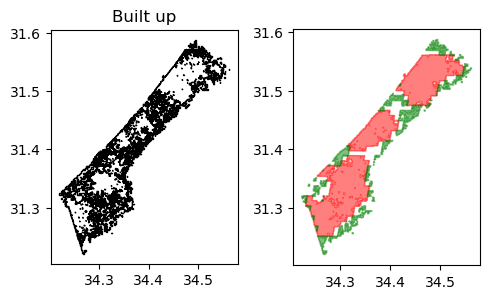

In [5]:
#Create 100m grid
# Get the extent of the boundary
xmin, ymin, xmax, ymax = Bound.total_bounds
# Create a GeoDataFrame of rectangular grids
grid = gpd.GeoDataFrame(geometry=[box(x, y, x + 100, y + 100) for x in range(int(xmin), int(xmax), 100) for y in range(int(ymin), int(ymax), 100)], crs=Bound.crs)

#Import and clip built up data
#WSF data
wsf_2019 = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019").filterBounds(Bound_geom).mosaic()
#Clip
wsf_2019_clipped = wsf_2019.clip(Bound_geom)

#Reclassify and select built up values
#Select built up area
Built = wsf_2019_clipped.gte(255)
Built = Built.updateMask(Built.neq(0))

#Convert built up vector to raster
# Create a Reducer object
reducer = ee.Reducer.mean()

# Convert the zones of the thresholded nightlights to vectors
vectors = Built.addBands(wsf_2019_clipped).reduceToVectors(
    geometry=Bound_geom,
    crs=wsf_2019_clipped.projection().getInfo()['crs'],
    scale=100,
    geometryType='polygon',
    eightConnected=False,
    labelProperty='built',
    reducer=reducer,
    maxPixels=1e13
)
# Convert the feature collection to a GeoDataFrame
wsf_2019_gdf = ee.FeatureCollection(vectors).getInfo()
wsf_2019_gdf = gpd.GeoDataFrame.from_features(wsf_2019_gdf, crs=boundary.crs)

# Reproject all datasets to the right projection
grid = grid.to_crs(epsg=4326)
urban_areas = urban_areas.to_crs(grid.crs)
rural_areas = rural_areas.to_crs(grid.crs)

# Perform spatial join between grid and urban areas
grid_within_aoi = gpd.sjoin(grid, wsf_2019_gdf, how='inner', predicate='intersects')
#Error check
# Check if 'index_left' exists, if yes, drop it
try:
    grid = grid_within_aoi.drop('index_left', axis=1)
except KeyError:
    pass

# Check if 'index_right' exists, if yes, drop it
try:
    grid = grid_within_aoi.drop('index_right', axis=1)
except KeyError:
    pass

grid_within_urban = gpd.sjoin(grid, urban_areas, how='inner', predicate='intersects')
#Error check
# Check if 'index_left' exists, if yes, drop it
try:
    grid = grid_within_aoi.drop('index_left', axis=1)
except KeyError:
    pass

# Check if 'index_right' exists, if yes, drop it
try:
    grid = grid_within_aoi.drop('index_right', axis=1)
except KeyError:
    pass

grid_within_rural = gpd.sjoin(grid, rural_areas, how='inner', predicate='intersects')

# Dissolve urban and rural areas
Urban02 = grid_within_urban.dissolve()
Rural02 = grid_within_rural.dissolve()


#Plot data
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
# Plot the built up data on the first subplot
wsf_2019_gdf.plot(edgecolor='black', facecolor='none', ax=ax1)
ax1.set_title('Built up')

# Plot the settlement boundaries on the second subplot
# Plot Urban areas
Urban02.plot(ax=ax2, color='red', edgecolor='red', alpha=0.5, label='Urban Areas')
Rural02.plot(ax=ax2, color='green', edgecolor='green', alpha=0.5, label='Rural Areas')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()




<h1><u><font color='red'>Step 3</font></u></h1>

#### Import Satellite data

<h4><font color='blue'>Create interactive map</font></h4>

<blockquote>To display all the data</blockquote>

In [6]:
#Create map
# Compute the centroid
centroid = BBox.geometry.centroid.iloc[0]  # Assuming there's only one geometry in the shapefile
longitude = centroid.x
latitude = centroid.y

#Create interactive map
#Get map

center = [latitude, longitude]
zoom = 10
Map_1 = geemap.Map(
    center=center,
    zoom=zoom,
    #interpolation="nearest",
    #basemap=basemaps.CartoDB.DarkMatter,
    add_google_map=False,
    ee_initialize=False,
)

#Add other basemaps
Map_1.add_basemap("Esri.WorldImagery")

#Visualize
Map_1

C:\Users\marti\AppData\Local\Temp\ipykernel_38696\3363353192.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = BBox.geometry.centroid.iloc[0]  # Assuming there's only one geometry in the shapefile


Map(center=[31.407520860658423, 34.403476687617335], controls=(WidgetControl(options=['position', 'transparent…

<h4><font color='blue'>Input study dates</font></h4>

<blockquote>Prewar and During war dates</blockquote>
<blockquote>or year of analysis date</blockquote>


In [7]:
start_date = '2022-12-01'
end_date = '2023-04-30'

<h4><font color='blue'>Load satellite imagery</font></h4>

<blockquote>Sentinel 2</blockquote>
<blockquote>Landsat 8 and 9</blockquote>
<blockquote>Modis Aqua</blockquote>

In [8]:
#Sentinel 2
#Load sentinel data
#Function to mask clouds from Sentinel-2 images
def maskS2clouds(image):
    # Select the QA60 band from the image
    qa = image.select('QA60')

    # Define the bit masks for clouds and cirrus clouds
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create a mask by checking if the corresponding bits in the QA60 band are clear
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
           .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the mask to the image and divide by 10000 to scale the pixel values
    return image.updateMask(mask).divide(10000)

# Load Sentinel-2 data and apply processing steps
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
     .filterDate(start_date, end_date) \
     .filterBounds(Bbox) \
     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
     .map(maskS2clouds)  

s2_Image = s2.mosaic().clip(Bbox);

# Get the band names of the image
band_names = s2_Image.bandNames()

# Print the band names
print('Sentinel band names:', band_names.getInfo())

# Add composite layer to the map
# Sentinel-2 visualization parameters
s2Viz = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}

Map_1.addLayer(s2_Image, s2Viz, 'Sentinel 2')

Sentinel band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


In [9]:
#Landsat 8 and 9
# Define the function to mask clouds from Landsat images
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())




# Load and process Landsat data
landsat8_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
       .filterBounds(Bound_geom))

landsat9_collection = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
       .filterBounds(Bound_geom))

# Merge the collections
Lc = landsat8_collection.merge(landsat9_collection)

# Filter by date and cloud cover
composite = Lc.filterDate(start_date, end_date).select('SR_B2','SR_B3','SR_B4', 'ST_B10', 'QA_PIXEL')
composite = composite.filter(ee.Filter.lt('CLOUD_COVER', 2))

# Define the function to apply scale factors
def apply_scale_factors(image):
    # Optical bands scaling
    optical_bands = image.select(['SR_B.']).multiply(0.0000275).add(-0.2)
    
    # Thermal bands scaling
    thermal_bands = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    
    # Add scaled bands to the image
    image = image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)
    
    return image

# Apply the scale factors function to the dataset
composite = composite.map(apply_scale_factors)

Lc_Image= composite.mean().clip(Bound_geom)

# Get the band names of the image
L_band_names = Lc_Image.bandNames().getInfo()

# Print the band names
print('Landsat_Band names:', L_band_names)

#Visualize
# Define visualization parameters
RGB_viz = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
}

# Add the layer to the map
Map_1.addLayer(Lc_Image, RGB_viz, 'Landsat True Color')


Landsat_Band names: ['SR_B2', 'SR_B3', 'SR_B4', 'ST_B10', 'QA_PIXEL']


In [10]:
#Modis aqua
# Function to extract QC bits
def get_qc_bits(image, start, end, new_name):
    pattern = 0
    for i in range(start, end+1):
        pattern += 2 ** i
    # Return a single band image of the extracted QC bits, giving the band a new name.
    return image.select([0], [new_name]) \
                 .bitwiseAnd(pattern) \
                 .rightShift(start)

# Function to mask out cloudy pixels & cloud state using the QC band.
def mask_qc(image):
    # Select the QC_Night and QC_Day bands from the MODIS data product
    QC = image.select(['QC_Night', 'QC_Day'])
    # Get the internal_cloud_algorithm_flag bit.
    cloud = get_qc_bits(QC, 0, 1, 'QC_state') \
                .expression("b(0) == 3 || b(0) == 2")
    error = get_qc_bits(QC, 6, 7, 'T_err') \
                .expression(" b(0) == 3")
    # Return an image masking out cloudy and low quality areas
    image = image.updateMask(error.Not())
    return image.updateMask(cloud.Not())

# Filter MODIS image collection by year, date ranges, and geographical boundaries.
collection = ee.ImageCollection('MODIS/061/MYD11A1') \
    .filterDate(start_date, end_date) \
    .map(mask_qc)

# Function to derive nighttime LST in Celsius
def rescale_night_lst(image):
    night_lst_c = image.expression(
        '(A * 0.02) - 273.15',
        {
            'A': image.select('LST_Night_1km')
        }
    ).rename('LSTN_C')
    return image.addBands(night_lst_c)

# Apply the function to the collection
collection = collection.map(rescale_night_lst)

# Clip the nighttime LST to study bounds
Mc_Image = collection.mean().clip(Bound_geom)

# Get the band names of the image
Mc_band_names = Mc_Image.bandNames().getInfo()

# Print the band names
print('Modis_Band names:', Mc_band_names)

Modis_Band names: ['LST_Day_1km', 'QC_Day', 'Day_view_time', 'Day_view_angle', 'LST_Night_1km', 'QC_Night', 'Night_view_time', 'Night_view_angle', 'Emis_31', 'Emis_32', 'Clear_day_cov', 'Clear_night_cov', 'LSTN_C']


<h1><u><font color='red'>Step 4</font></u></h1>

#### Urban Heat Analysis

<h4><font color='blue'>Load satellite imagery</font></h4>

<blockquote>Land Surface Temperature (LST)
<blockquote>
    <p>Daytime - Landsat</p>
    <p>Nighttime - Modis Aqua</p>
</blockquote></blockquote></blockquote>

#### Day time

In [11]:
#Select LST band
LST = Lc_Image.select("ST_B10").rename('LST')

# Compute minimum, maximum, mean and stdDev values
LST_min_max = LST.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=Bound_geom,
    scale=30
) 
# Get minimum and maximum values
LST_min_value = LST_min_max.get('LST_min').getInfo()
LST_max_value = LST_min_max.get('LST_max').getInfo()


# Compute standard deviation
LST_std_dev = LST.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=Bound_geom,
    scale=30
)
# Get standard deviation value
LST_std_value = LST_std_dev.get('LST').getInfo()

# Apply the mean reducer to the entire collection
LST_mean = LST.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=Bound_geom,
    scale=30
)
# Get mean value
LST_mean_value = LST_mean.get('LST').getInfo()

#Visualization parameters for surface temperature
LST_visParam = {
  #"bands": "LST",
  "min": LST_min_value,
  "max": LST_max_value,
  #"palette": ['blue', 'white', 'red'],
  "palette": ['blue', 'limegreen', 'yellow', 'darkorange', 'red'],
  "opacity": 1
}

#Add to map
Map_1.addLayer(LST, LST_visParam,"Land Surface temperature")

#Add legend
Map_1.add_colorbar(
    LST_visParam,
    label="Temperature (degrees Celsius)",
    layer_name="LST",
    orientation="horizontal",
    position="bottomright",
    transparent_bg=True,
    discrete=True,
)

# Print the values
print("Minimum value:", LST_min_value)
print("Maximum value:", LST_max_value)
print("Standard deviation value:", LST_std_value)
print("mean value:", LST_mean_value)

Minimum value: 20.981977550000007
Maximum value: 36.61998872000002
Standard deviation value: 1.8908200860419409
mean value: 28.78680134879551


#### Night time

In [12]:
# Select the nighttime LST band
values_lstn = Mc_Image.select("LSTN_C")


# Compute minimum, maximum, mean and stdDev values
LSTmodis_min_max = values_lstn.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=Bound_geom,
    scale=30
) 
# Get minimum and maximum values
LSTmodis_min_value = LSTmodis_min_max.get("LSTN_C_min").getInfo()
LSTmodis_max_value = LSTmodis_min_max.get("LSTN_C_max").getInfo()

# Compute standard deviation
LSTmodis_std_dev = values_lstn.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=Bound_geom,
    scale=30
)
# Get standard deviation value
LSTmodis_std_value = LSTmodis_std_dev.get('LSTN_C').getInfo()

# Apply the mean reducer to the entire collection
LSTmodis_mean = values_lstn.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=Bound_geom,
    scale=30
)
# Get mean value
LSTmodis_mean_value = LSTmodis_mean.get('LSTN_C').getInfo()

# Print the values
print("Minimum value:", LSTmodis_min_value)
print("Maximum value:", LSTmodis_max_value)
print("Standard deviation:", LSTmodis_std_value)
print("mean value:", LSTmodis_mean_value)

#Visualization parameters for surface temperature
LSTn_visParam = {
    #"bands": "LST",
    "min": LSTmodis_min_value, 
    "max": LSTmodis_max_value,
    "palette": ['blue', 'white', 'red'],
    #"palette": ['blue', 'limegreen', 'yellow', 'darkorange', 'red'],
    "opacity": 1
}

#Add to map
Map_1.addLayer(values_lstn, LSTn_visParam,"Land Surface temperature (Night - Modis)")


Minimum value: 8.665652173913076
Maximum value: 15.248695652173947
Standard deviation: 1.2742159074491004
mean value: 11.192776451391381


#### Combination of both day and night lst

In [13]:
# Add the two images together
LSTlm = LST.add(values_lstn)

# Divide the sum by 2 to get the mean
LSTlm = LSTlm.divide(2)

# Compute minimum, maximum, mean and stdDev values
LSTlm_min_max = LSTlm.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=Bound_geom,
    scale=30
) 
# Get minimum and maximum values
LSTlm_min_value = LSTlm_min_max.get('LST_min').getInfo()
LSTlm_max_value = LSTlm_min_max.get('LST_max').getInfo()

# Compute standard deviation
LSTlm_std_dev = LSTlm.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=Bound_geom,
    scale=30
)
# Get standard deviation value
LSTlm_std_value = LSTlm_std_dev.get('LST').getInfo()

# Apply the mean reducer to the entire collection
LSTlm_mean = LSTlm.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=Bound_geom,
    scale=30
)
# Get mean value
LSTlm_mean_value = LSTlm_mean.get('LST').getInfo()

# Print the values
print("Minimum value:", LSTlm_min_value)
print("Maximum value:", LSTlm_max_value)
print("Standard Deviation:", LSTlm_std_value)
print("Mean value:", LSTlm_mean_value)

#Visualization parameters for surface temperature
LSTdn_visParam = {
    #"bands": "LST",
    "min": LSTlm_min_value, 
    "max": LSTlm_max_value,
    #"palette": ['blue', 'white', 'red'],
    "palette": ['blue', 'limegreen', 'yellow', 'darkorange', 'red'],
    "opacity": 1
}


Map_1.addLayer(LSTlm, LSTdn_visParam,"Land Surface temperature (Day night mean)")


#3D Visualization
dem = ee.Image("CGIAR/SRTM90_V4").clip(Bound_geom)

LSTib = geemap.blend(LSTlm.clip(Bound_geom), dem, top_vis=LSTdn_visParam, expression="a*b")


Map_1.addLayer(LSTib, {}, "GazaLST")


Minimum value: 17.10779882893942
Maximum value: 24.140650346111137
Standard Deviation: 1.0737858674327883
Mean value: 19.991556864931784


<h1><u><font color='red'>Step 5</font></u></h1>

#### Vulnerability index

<h4><font color='blue'>Calculate indices</font></h4>

<blockquote>
    <p>Normalized Difference Vegetation Index(NDVI)</p>
    <p>Bare Soil Index(BSI)</p>
</blockquote></blockquote>

In [14]:
#Select bands (Select bands for NIR, SWIR, and Red)
nirBand = s2_Image.select('B8').clip(Bound_geom)
swirBand = s2_Image.select('B11').clip(Bound_geom)
redBand = s2_Image.select('B4').clip(Bound_geom)
greenBand = s2_Image.select('B3').clip(Bound_geom)
blueBand = s2_Image.select('B2').clip(Bound_geom)
swir2Band = s2_Image.select('B12').clip(Bound_geom)

s2bands_indices = ee.Image([greenBand, redBand, swirBand, nirBand, blueBand, swir2Band]);

#Calculate NDVI

#Calculate NDVI
#ndvi = nirBand.subtract(redBand).divide(nirBand.add(redBand)).rename('NDVI');
ndvi = s2bands_indices.normalizedDifference(['B8', 'B4']).rename('NDVI')

#Add indices to map
Map_1.addLayer(ndvi, {"min": -1, "max": 1, "palette": ['blue', 'white', 'green']},"NDVI")

#Get min and max stats for NDVI
indice_composite = ee.Image([ndvi]);
#Get min and max of ndvi
# Function to compute min and max values
# Compute minimum and maximum values
indices_min_max = indice_composite.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=Bound_geom,
    scale=30
) 

# Compute standard deviation
indices_std_dev = indice_composite.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=Bound_geom,
    scale=30
) 

#Get individual stats
# Get minimum and maximum values NDVI
NDVI_min_value = indices_min_max.get('NDVI_min').getInfo()
NDVI_max_value = indices_min_max.get('NDVI_max').getInfo()
# Get standard deviation value
NDVI_std_value = indices_std_dev.get('NDVI').getInfo()

# Apply the mean reducer
NDVI_mean = indice_composite.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=Bound_geom,
    scale=30
)
# Get mean value
NDVI_mean_value = NDVI_mean.get('NDVI').getInfo()

# Print the values
print("Minimum value:", NDVI_min_value)
print("Maximum value:", NDVI_max_value)
print("Standard deviation value:", NDVI_std_value)
print("mean value:", NDVI_mean_value)


Minimum value: -0.4942528679383344
Maximum value: 0.9089066081710333
Standard deviation value: 0.17030029053638673
mean value: 0.28560165304677276


#### Get population data.

In [15]:
##Add population variable
#Vulnerability map
#Import population dataset (2020 world pop)

# Area of interest
pop_2020 = ee.Image('JRC/GHSL/P2023A/GHS_POP/2020')
pop_2020 = pop_2020.updateMask(pop_2020.gte(0))


pop_2020_clipped = pop_2020.clip(Bound_geom)

populationCountVis = {
  'palette' : ['000004', '320A5A', '781B6C', 'BB3654', 'EC6824', 'FBB41A', 'FCFFA4']
}

Map_1.addLayer(pop_2020_clipped, populationCountVis, 'Population',  True)

#Get min and max of pop data
# Function to compute min and max values
# Compute minimum and maximum values
pop_min_max = pop_2020_clipped.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=Bound_geom,
    scale=100
) 
# Convert ndvi_min_max to a Python dictionary
pop_min_max_dict = pop_min_max.getInfo()

# Compute standard deviation
pop_std_dev = pop_2020_clipped.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=Bound_geom,
    scale=100
)

# Apply the mean reducer to the entire collection
pop_mean = pop_2020_clipped.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=Bound_geom,
    scale=100
)

#Get stats
# Get minimum and maximum values
pop_min_value = pop_min_max.get('population_count_min').getInfo()
pop_max_value = pop_min_max.get('population_count_max').getInfo()
pop_std_value = pop_std_dev.get('population_count').getInfo()
pop_mean_value = pop_mean.get('population_count').getInfo()

# Print the values
print("Minimum value: {:.0f}".format( pop_min_value))
print("Maximum value: {:.0f}".format(pop_max_value))
print("Standard Deviation: {:.0f}".format(pop_std_value))
print("Mean value: {:.0f}".format( pop_mean_value))

total = pop_2020_clipped.reduceRegion(reducer=ee.Reducer.sum(), geometry=Bound_geom).get('population_count').getInfo()
print("Total Population: {:.0f}".format(total))



Minimum value: 0
Maximum value: 564
Standard Deviation: 78
Mean value: 49
Total Population: 1798278


#### Standardize images and reclassify

In [16]:
LSTlm_std = (LSTlm.subtract(LSTlm_mean_value)).divide(LSTlm_std_value)
NDVI_std = (ndvi.subtract(NDVI_mean_value)).divide(NDVI_std_value)
POP_std = (pop_2020_clipped.subtract(pop_mean_value)).divide(pop_std_value)


In [17]:
#Get min and max stats for NDVI, NDWI and BSI
hvi_composite = ee.Image([LSTlm_std, POP_std, NDVI_std]);

#Get min and max of lst, ndwi, ndvi and bsi
# Function to compute min and max values
# Compute minimum and maximum values
hvi_composite_min_max = hvi_composite.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=Bound_geom,
    scale=30
) 

# Convert hvi_min_max to a Python dictionary
hvi_composite_min_max_dict = hvi_composite_min_max.getInfo()

# Print the properties of ndvi_min_max
print("Properties of hvi_composite_min_max:")
for key, value in hvi_composite_min_max_dict.items():
    print(key + ":", value)

Properties of hvi_composite_min_max:
LST_max: 3.8639859277520787
LST_min: -2.6855987990295174
NDVI_max: 3.660034596306715
NDVI_min: -4.579290607953964
population_count_max: 6.5640403499733
population_count_min: -0.628481138595714


In [23]:
LST_hvi = ee.Image(1).where(LSTlm_std.lte(-2), 1)\
                     .where((LSTlm_std.gt(-2)).And(LSTlm_std.lte(-1)), 2)\
                     .where((LSTlm_std.gt(-1)).And(LSTlm_std.lte(0)), 3)\
                     .where((LSTlm_std.gt(0)).And(LSTlm_std.lte(1)), 4)\
                     .where((LSTlm_std.gt(1)).And(LSTlm_std.lte(2)), 5)\
                     .where(LSTlm_std.gt(2), 6)

NDVI_hvi = ee.Image(1).where(NDVI_std.lte(-2), 6)\
                      .where((NDVI_std.gt(-2)).And(NDVI_std.lte(-1)), 5)\
                      .where((NDVI_std.gt(-1)).And(NDVI_std.lte(0)), 4)\
                      .where((NDVI_std.gt(0)).And(NDVI_std.lte(1)), 3)\
                      .where((NDVI_std.gt(1)).And(NDVI_std.lte(2)), 2)\
                      .where(NDVI_std.gt(2), 1)

POP_hvi = ee.Image(1).where(POP_std.lte(-2), 1)\
                     .where((POP_std.gt(-2)).And(POP_std.lte(-1)), 2)\
                     .where((POP_std.gt(-1)).And(POP_std.lte(0)), 3)\
                     .where((POP_std.gt(0)).And(POP_std.lte(1)), 4)\
                     .where((POP_std.gt(1)).And(POP_std.lte(2)), 5)\
                     .where(POP_std.gt(2), 6)


urban_heat_vulnerability = LST_hvi.add(NDVI_hvi).add(POP_hvi)

#Add to map
# Compute minimum and maximum values
uhv_min_max = urban_heat_vulnerability.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=Bound_geom,
    scale=30
) 

uhv_min_value = uhv_min_max.get('constant_min').getInfo()
uhv_max_value = uhv_min_max.get('constant_max').getInfo()

uhv_mean = urban_heat_vulnerability.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=Bound_geom,
    scale=1000
) 
uhv_mean_value = uhv_mean.get('constant').getInfo()

print("Min value:", uhv_min_value)
print("Max value:", uhv_max_value)
print("Mean Vulnerability:", uhv_mean_value)

hvi_visParam = {
    #"bands": "LST",
    "min": uhv_min_value, 
    "max": uhv_max_value,
    #"palette": ['red', 'white','blue'],
    "palette": ['blue', 'limegreen', 'yellow', 'darkorange', 'red'],
    "opacity": 1
}

Map_1.addLayer(LST_hvi.clip(Bound_geom), {"min": 1, "max": 6,"palette": ['blue', 'limegreen', 'yellow', 'darkorange', 'red'],"opacity": 1}, "LST_hvi")
Map_1.addLayer(urban_heat_vulnerability.clip(Bound_geom), hvi_visParam, "urban_heat_vulnerability")


Min value: 5
Max value: 17
Mean Vulnerability: 10.498884881191664
